# Explore billionaire dataset

Explore global wealth dynamics with our dataset: [all_billionaires_1997_2023.csv](https://www.kaggle.com/datasets/guillemservera/forbes-billionaires-1997-2023)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.linear_model import LinearRegression
from bokeh.models import ColumnDataSource, Range1d
from bokeh.io import show, output_notebook, push_notebook
from bokeh.palettes import Spectral10, Spectral5, Category20
from bokeh.plotting import figure, show, output_file, save
from bokeh.transform import factor_cmap, factor_mark
from bokeh.layouts import column

import time

df_all = pd.read_csv("all_billionaires_1997_2023.csv")

# data process
df_cleaned = df_all[df_all['year'] > 2009].copy()
df_cleaned['business_industries'] = df_cleaned['business_industries'].apply(lambda x: np.nan if pd.isnull(x) else ''.join(x.split()).replace('[\'', '').replace('\']', '').replace('#38;', '').replace('and', '&'))
## Eliminate duplicates
df_cleaned['business_industries'] = df_cleaned['business_industries'].apply(lambda x: np.nan if pd.isnull(x) else ''.join(x.split()).replace('[\'', '').replace('\']', '').replace('#38;', '').replace('and', '&'))
df_cleaned['business_industries'] = df_cleaned['business_industries'].replace(['Finance', 'Investments', 'Finance&Investments'], 'Finance&Investments')
df_cleaned['business_industries'] = df_cleaned['business_industries'].replace(['Media', 'Media&Entertainment'], 'Media&Entertainment')
df_cleaned['business_industries'] = df_cleaned['business_industries'].replace(['Gaming', 'Casinos&Gaming'], 'Casinos&Gaming')
df_cleaned['business_industries'] = df_cleaned['business_industries'].replace(['Food', 'Food&Beverage','Beverages'], 'Food&Beverage')
df_cleaned['business_industries'] = df_cleaned['business_industries'].replace(['Retail', 'Fashion&Retail'], 'Fashion&Retail')
df_cleaned['business_industries'] = df_cleaned['business_industries'].replace(['Telecom', 'Telecommunications'], 'Telecom')
## drop nan and meaningless content
df_cleaned = df_cleaned.dropna(subset=['business_industries','country_of_residence','age','gender'])
df_cleaned = df_cleaned[~df_cleaned['business_industries'].str.contains('billionaire', case=False, na=False)]
## format net_worth form num B -> num
df_cleaned['net_worth'] = df_cleaned['net_worth'].str.replace(' B', '').astype(float)
# top10 industries
industry_net_worth = df_cleaned.groupby('business_industries')['net_worth'].sum()
top10_industries = industry_net_worth.nlargest(10)
focus_industries = top10_industries.index.tolist()

## Billionaire counts with industries over years

In [3]:
# creat new dataframe for figure1
df_focus_industry = df_cleaned[df_cleaned['business_industries'].isin(focus_industries)].copy()
df_focus_industry['amount'] = 1
df_focus_industry['year'] = df_focus_industry['year'].astype(str)
df_pivot = df_focus_industry.pivot_table(index='year', columns='business_industries', values='amount', aggfunc='sum')
df_pivot.columns = [str(col) for col in df_pivot.columns]
# top5 countries
billionaires_by_country = df_focus_industry.groupby('country_of_residence').size()
top5_countries = billionaires_by_country.nlargest(5).index.tolist()

In [4]:
output_notebook()
# interactive test
years = [str(year) for year in range(2010, 2024)]
industries = df_pivot.columns.tolist()
source = ColumnDataSource(df_pivot)

Loading BokehJS ...

In [5]:
p = figure(x_range=years, height=400, width = 900, title="Billionaires counts by Industry Over Years",
           toolbar_location=None)

for name, color in zip(industries, Spectral10):
    data = source.data[name]
    df = pd.DataFrame(data)
    p.line(years, df[0], line_width=2, color=color, alpha=0.8,
           muted_color=color, muted_alpha=0.2, legend_label=name)

p.legend.location = "top_left"
p.legend.click_policy="mute"

handle = show(p, notebook_handle=True)

for i in range(10):
    source.data['x'] = [i]
    source.data['y'] = [i]
    push_notebook(handle=handle)
    time.sleep(1)

# output_file("industries.html")
save(p)

'/tmp/tmpfxrocthm.html'

In terms of industries, both the **Energy** and **Media & Entertainment** sectors have shown minimal variations in billionaire counts over the past 14 years, indicating that wealth in these fields remains concentrated among specific individuals, suggesting limited liquidity within these sectors. 

The substantial increase in the number of billionaires in the Finance & Investments, Manufacturing, and Technology industries, with Manufacturing and Technology doubling their counts, reflects significant growth in these sectors.

However, the decline in billionaire counts across most industries since 2020 suggests a potential economic slowdown. This decline could be attributed to increased global economic uncertainty, supply chain issues, and a decrease in consumer confidence, affecting various sectors differently.

## All billionaires in top10 industries

In [7]:
df_industry_country = df_focus_industry[df_focus_industry['country_of_residence'].isin(top5_countries)].copy()
attributes = ['year', 'age', 'net_worth', 'business_industries', 'country_of_residence']
df_multi = df_industry_country[attributes].copy()
df_multi = df_multi[df_multi['age'] != 0].copy()
df_multi['scaled_worth'] = df_multi['net_worth'] / 10
p_multi = figure(title="Net Worth by Age", background_fill_color="#fafafa", width = 1000, height = 700)
p_multi.xaxis.axis_label = 'Ages'
p_multi.yaxis.axis_label = 'Net Worth(B)'

MARKERS = ['hex', 'circle_x', 'triangle', 'square', 'cross']

for index, name in enumerate(top5_countries):
    country_data = df_multi[df_multi['country_of_residence'] == name].copy()
    source = ColumnDataSource(data={'age': country_data['age'].tolist(), 'net_worth': country_data['net_worth'].tolist(),
                   'country_of_residence': country_data['country_of_residence'].tolist()})
    color = Spectral5[index % len(Spectral5)]
    p_multi.scatter("age", "net_worth", source=source,
              legend_group="country_of_residence", fill_alpha=0.4, size=8,
              marker=MARKERS[index],
              color=color)

p_multi.legend.location = "top_left"
p_multi.legend.click_policy = "hide"
p_multi.legend.title = "Top 5 Countries"
show(p_multi)
save(p_multi)

'/tmp/tmpea9rx60_.html'

The analysis highlights significant age disparities among billionaires across different countries. 

In the **United States**, the age range spans from 21 to 101 years old, making it the country with the widest age range among billionaires. In **Russia**, billionaires' ages range from 24 to 68, indicating a relatively narrower age range.

**Indian** billionaires tend to be around 60 years old, suggesting a concentration of wealth in this age group. **German** billionaires, on the other hand, show a diverse age distribution, with a notable concentration of wealth among individuals over 60, although no linear relationship is observed. 

# Top10%, top10%-20%, bottom80% average wealth of the year

In [13]:
def calculate_average_net_worth(df, year, p):
    data_year = df[df['year'] == year].copy()
    index = int(len(data_year) * p)
    top_p_net_worth = data_year.nlargest(index, 'net_worth')['net_worth'].sum()
    total_billionaires = len(data_year)
    average_net_worth = top_p_net_worth / total_billionaires
    return average_net_worth

top_10pct_avg = []
mid_10pct_avg = []
bottom_80pct_avg = []

for year in years:
    top_10pct_avg.append(calculate_average_net_worth(df_focus_industry, year, 0.1))
    mid_10pct_avg.append(calculate_average_net_worth(df_focus_industry, year, 0.2))
    bottom_80pct_avg.append(calculate_average_net_worth(df_focus_industry, year, 0.8))

data = {
    'Year': years,
    'Top 10% Avg Net Worth': top_10pct_avg,
    '10%-20% Avg Net Worth': mid_10pct_avg,
    'Bottom 80% Avg Net Worth': bottom_80pct_avg
}
df_avg_net_worth = pd.DataFrame(data)
p_average = figure(width=800, height=400, title='Average Net Worth')
p_average.line(df_avg_net_worth['Year'], df_avg_net_worth['Top 10% Avg Net Worth'], line_width=2, legend_label='Top 10%')
p_average.line(df_avg_net_worth['Year'], df_avg_net_worth['10%-20% Avg Net Worth'], line_width=2, line_color='orange', legend_label='10%-20%')
p_average.line(df_avg_net_worth['Year'], df_avg_net_worth['Bottom 80% Avg Net Worth'], line_width=2, line_color='green', legend_label='Bottom 80%')
p_average.y_range.start = 0  

p_average.legend.location = 'top_left'
p_average.xaxis.axis_label = 'Year'
p_average.yaxis.axis_label = 'Average Net Worth (in Billion $)'
show(p_average)
# output_file("average.html")
save(p_average)

'/tmp/tmp0_xg0mnb.html'

The analysis demonstrates a significant disparity in wealth between the top 10% of billionaires and those in the 10%-20% bracket. From 2010, the average wealth of the top 10% of billionaires was twice that of the 10%-20% bracket, increasing to three times by 2023. 

This widening wealth gap between the wealthiest individuals and those moderately wealthy highlights a growing inequality trend over the years, indicating that the richest billionaires are amassing wealth at a much faster rate than the rest.

# Gap counts between female and male billionaires

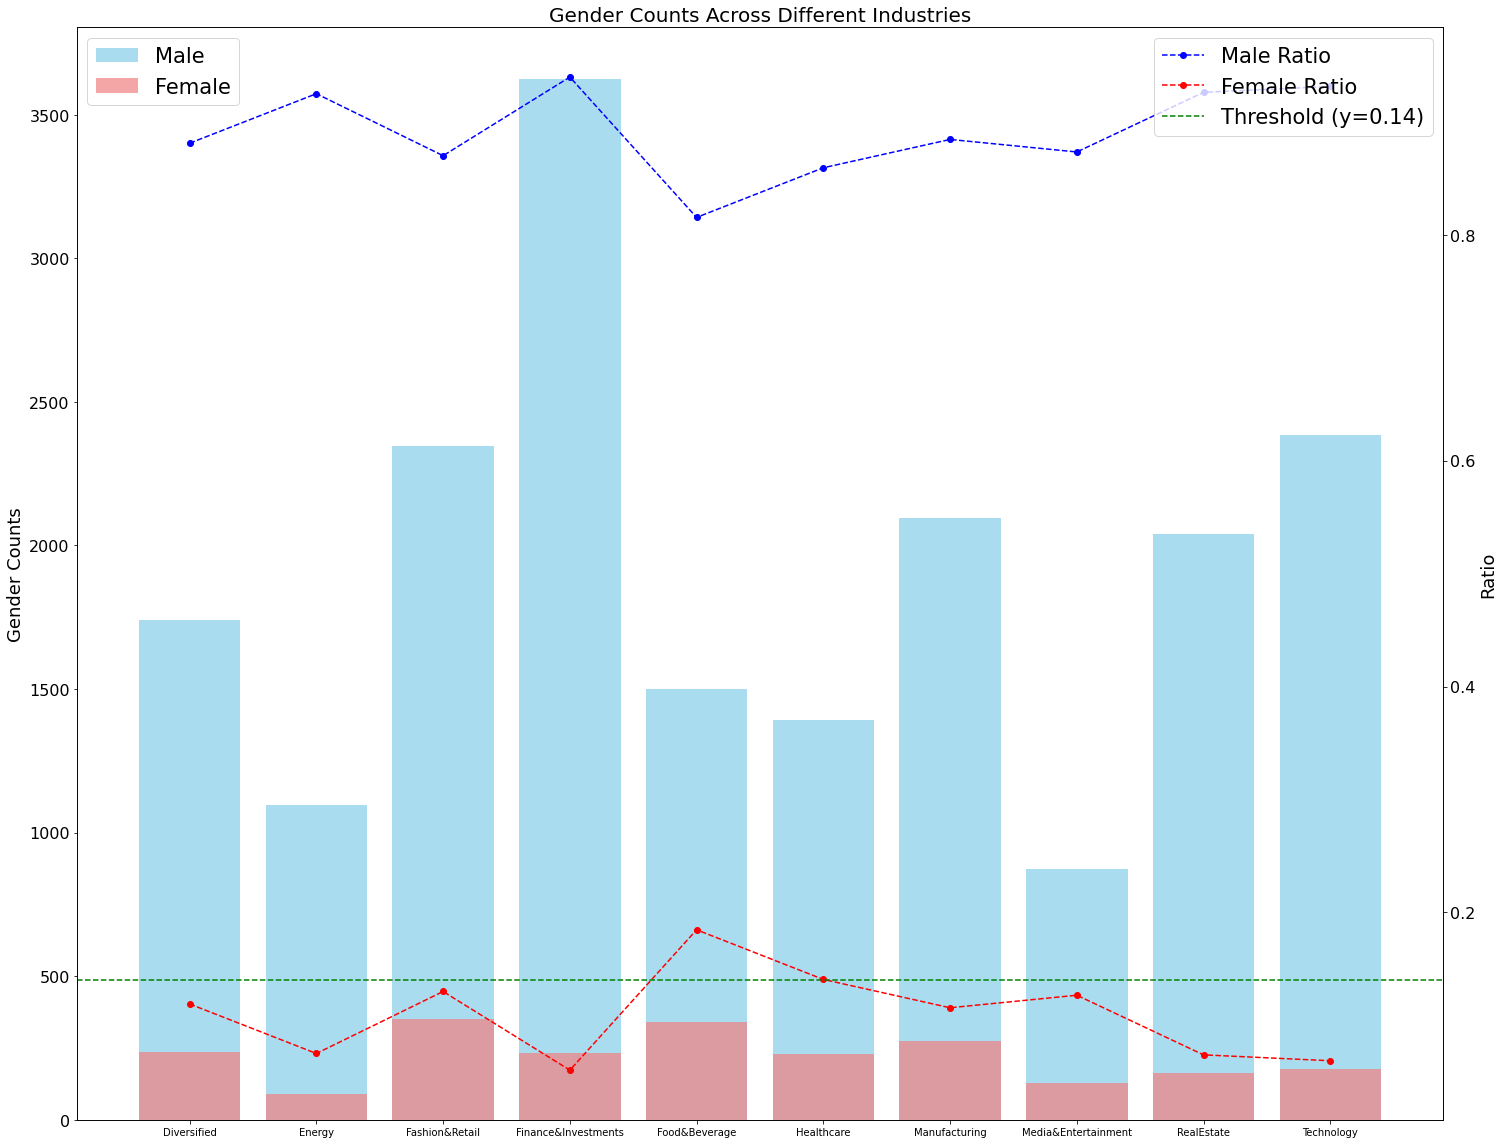

In [14]:
gender_counts_industry = df_focus_industry.groupby(['business_industries', 'gender']).size().unstack().fillna(0)
total_counts_industry = gender_counts_industry['Male'] + gender_counts_industry['Female']
male_ratios = gender_counts_industry['Male'] / total_counts_industry
female_ratios = gender_counts_industry['Female'] / total_counts_industry

fig, ax1 = plt.subplots(figsize=(21, 16))
ax1.bar(gender_counts_industry.index, gender_counts_industry['Male'], label='Male', color='skyblue', alpha=0.7)
ax1.bar(gender_counts_industry.index, gender_counts_industry['Female'], label='Female', color='lightcoral', alpha=0.7)
ax1.set_ylabel('Gender Counts', color='black', fontsize=18)
ax1.tick_params(axis='y', labelcolor='black', labelsize=16)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(gender_counts_industry.index, male_ratios, label='Male Ratio', color='blue', marker='o', linestyle='--')
ax2.plot(gender_counts_industry.index, female_ratios, label='Female Ratio', color='red', marker='o', linestyle='--')
ax2.axhline(y=0.14, color='green', linestyle='--', label='Threshold (y=0.14)')
ax2.set_ylabel('Ratio', color='black', fontsize=18)
ax2.tick_params(axis='y', labelcolor='black', labelsize=16)
ax2.legend(loc='upper right')

plt.xlabel('Industry', fontsize=18)
plt.xticks(rotation=90, ha='center', fontsize=16)
plt.ylabel('Ratio', fontsize=18)

plt.title('Gender Counts Across Different Industries', fontsize=20) 
plt.yticks(fontsize=16)

plt.tight_layout()
legend = ax1.legend(loc='upper left', fontsize=21)
legend2 = ax2.legend(loc='upper right', fontsize=21)
plt.savefig('gender.png')
plt.show()

The gender disparity among billionaires is substantial, both in terms of quantity and proportion. Among the top industries with the highest cumulative wealth, the food & beverage sector has the highest number of female billionaires, while the energy sector has the fewest. 

Additionally, in the finance & investment industry, the number of male billionaires significantly outweighs that of female billionaires. These observations underline the pronounced gender gap in billionaire representation across various industries, with notable differences in both numbers and proportions.
